## Installing Transformers and Sentencepiece

In [ ]:
#install transformes 
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.4 MB/s 
     |████████████████████████████████| 101 kB 9.6 MB/s 
     |████████████████████████████████| 6.6 MB 36.7 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.8 MB/s 


## Necessary imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, get_scheduler
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import random
from tqdm.auto import tqdm

## 1.1 - Installing Urdu-Sentiment-Corpus (GitHub)

Source: https://github.com/MuhammadYaseenKhan/Urdu-Sentiment-Corpus

Total Instances: 1000

Summary: Used for sentiment analysis and polarity detection through tweets about pakistani politics.

Validity: The dataset is used in an authentic paper published by IEEE in 2020 International Conference on Information Science and Communication Technology (ICISCT) - https://ieeexplore.ieee.org/abstract/document/9080043/.

In [ ]:
!git clone https://github.com/MuhammadYaseenKhan/Urdu-Sentiment-Corpus.git

Cloning into 'Urdu-Sentiment-Corpus'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 57 (delta 12), reused 36 (delta 7), pack-reused 15
Unpacking objects: 100% (57/57), done.


In [ ]:
d1 = pd.read_csv("/content/Urdu-Sentiment-Corpus/urdu-sentiment-corpus-v1.tsv", sep='\t', skip_blank_lines=True, encoding='utf-8')
d1["Class"].replace(['P', 'N', 'O'], [0, 1, 2], inplace=True) # formatting sentiment lablelling
d1.rename(columns={"Tweet": "Text", "Class": "Sentiment"}, inplace=True) # renaming column to ensure same format of all datasets

d1

,Text,Sentiment
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,0.0
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,1.0
2,ٹویٹر کا خیال کیسے آیا ؟,2.0
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",0.0
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,0.0
...,...,...
995,اُس آدمی نے اِس سالار کو کافی معقول ٹپ دی ہے ۔,0.0
996,چچا غالب کی روح سے معذرت کے ساتھہم نے مانا کہ ...,0.0
997,واہ جناب واہ! اچھی رہی۔ جناب خود کو فرشتہ سمجو...,0.0
998,اسلام آباد :پی اے ٹی کا دھرنا ختم، صفائی کے کا...,0.0


## 1.2 - Visualizing the data of Dataset 1

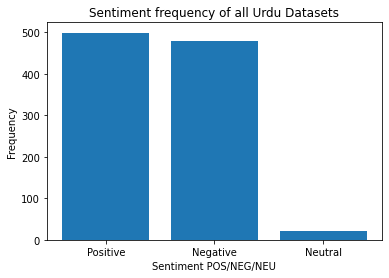

Positive 499, Negative 480, Neutral 20


In [ ]:
y = list(d1["Sentiment"].value_counts()) # getting frequency of all the 2 sentiments
plt.plot()
plt.bar(["Positive", "Negative", "Neutral"], y) # plottign frequency against labels in a bar chart
plt.xlabel("Sentiment POS/NEG/NEU")
plt.ylabel("Frequency")
plt.title("Sentiment frequency of all Urdu Datasets")
plt.show()

print("Positive {}, Negative {}, Neutral {}".format(y[0], y[1], y[2]))

## Importing Tokenizer

In [ ]:
# Download the tokenizer for the XLM-Robert `base` model.
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

## Sample tokenization of text (and checking data)

In [ ]:
#xlmr_tokenizer creates tokens based on subword
print("sample text = ", d1.Text[1])
tokens = xlmr_tokenizer.tokenize(d1.Text[1])
print("XLMR Roberta covert sample text into following tokens \n ", tokens)

sample text =  چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن سکتے 
XLMR Roberta covert sample text into following tokens 
  ['▁چند', 'ے', '▁سے', '▁انقلاب', '▁اور', '▁عمران', '▁خان', '▁وزیر', '▁اعظم', '▁نہیں', '▁بن', '▁سکتے']


In [ ]:
#some samples from data frame
print(d1.Text[1])
print(d1.Text[2])
print(d1.Text[3])

چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن سکتے 
 ٹویٹر کا خیال کیسے آیا ؟
سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000 فٹ کی بلندی پر چھلانگ لگا کر عالمی ریکارڈ قائم کرلیا۔ چھلانگ کی۔۔۔ 


In [ ]:
#checking the sentiment values 
#later on we will convert them into categorie i.e, integers
d1['Sentiment']

0      0.0
1      1.0
2      2.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: Sentiment, Length: 1000, dtype: float64

In [ ]:
#accessing the sentiments for first few samples 
print(d1.at[0,'Sentiment'])
print(d1.at[1,'Sentiment'])
print(d1.at[2,'Sentiment'])

0.0
1.0
2.0


## ***Encoding all samples while varying the max_length hyperparameter***

## 1. First run:
    - Hyperparameters:
        - max_length = 50
        - epochs = 5
        - batch_size = 16

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 50,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=16

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 5
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch: 1
Epoch:  5
XLMR- validation accuracy  0.42
------------------------------------ 
Epoch: 2
Epoch:  5
XLMR- validation accuracy  0.55
------------------------------------ 
Epoch: 3
Epoch:  5
XLMR- validation accuracy  0.61
------------------------------------ 
Epoch: 4
Epoch:  5
XLMR- validation accuracy  0.64
------------------------------------ 
Epoch: 5
Epoch:  5
XLMR- validation accuracy  0.65
------------------------------------ 


## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.65


## 2. Second run:
    - Hyperparameters:
        - max_length = 50
        - epochs = 15
        - batch_size = 16

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 50,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=16

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 15
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/855 [00:00<?, ?it/s]

Epoch: 1
Epoch:  15
XLMR- validation accuracy  0.51
------------------------------------ 
Epoch: 2
Epoch:  15
XLMR- validation accuracy  0.52
------------------------------------ 
Epoch: 3
Epoch:  15
XLMR- validation accuracy  0.51
------------------------------------ 
Epoch: 4
Epoch:  15
XLMR- validation accuracy  0.53
------------------------------------ 
Epoch: 5
Epoch:  15
XLMR- validation accuracy  0.58
------------------------------------ 
Epoch: 6
Epoch:  15
XLMR- validation accuracy  0.56
------------------------------------ 
Epoch: 7
Epoch:  15
XLMR- validation accuracy  0.59
------------------------------------ 
Epoch: 8
Epoch:  15
XLMR- validation accuracy  0.57
------------------------------------ 
Epoch: 9
Epoch:  15
XLMR- validation accuracy  0.64
------------------------------------ 
Epoch: 10
Epoch:  15
XLMR- validation accuracy  0.68
------------------------------------ 
Epoch: 11
Epoch:  15
XLMR- validation accuracy  0.64
------------------------------------ 
Epoch: 1

## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.65


## 3. Third run:
    - Hyperparameters:
        - max_length = 80
        - epochs = 30
        - batch_size = 32

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 80,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=32

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 30
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/870 [00:00<?, ?it/s]

Epoch: 1
Epoch:  30
XLMR- validation accuracy  0.52
------------------------------------ 
Epoch: 2
Epoch:  30
XLMR- validation accuracy  0.55
------------------------------------ 
Epoch: 3
Epoch:  30
XLMR- validation accuracy  0.54
------------------------------------ 
Epoch: 4
Epoch:  30
XLMR- validation accuracy  0.55
------------------------------------ 
Epoch: 5
Epoch:  30
XLMR- validation accuracy  0.56
------------------------------------ 
Epoch: 6
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 7
Epoch:  30
XLMR- validation accuracy  0.72
------------------------------------ 
Epoch: 8
Epoch:  30
XLMR- validation accuracy  0.64
------------------------------------ 
Epoch: 9
Epoch:  30
XLMR- validation accuracy  0.75
------------------------------------ 
Epoch: 10
Epoch:  30
XLMR- validation accuracy  0.72
------------------------------------ 
Epoch: 11
Epoch:  30
XLMR- validation accuracy  0.75
------------------------------------ 
Epoch: 1

## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.77


## 4. Fourth run:
    - Hyperparameters:
        - max_length = 40
        - epochs = 30
        - batch_size = 32

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 30,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=32

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 30
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/870 [00:00<?, ?it/s]

Epoch: 1
Epoch:  30
XLMR- validation accuracy  0.56
------------------------------------ 
Epoch: 2
Epoch:  30
XLMR- validation accuracy  0.47
------------------------------------ 
Epoch: 3
Epoch:  30
XLMR- validation accuracy  0.6
------------------------------------ 
Epoch: 4
Epoch:  30
XLMR- validation accuracy  0.58
------------------------------------ 
Epoch: 5
Epoch:  30
XLMR- validation accuracy  0.59
------------------------------------ 
Epoch: 6
Epoch:  30
XLMR- validation accuracy  0.65
------------------------------------ 
Epoch: 7
Epoch:  30
XLMR- validation accuracy  0.65
------------------------------------ 
Epoch: 8
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 9
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 10
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 11
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 12

## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.72


## 5. Fifth run:
    - Hyperparameters:
        - max_length = 100
        - epochs = 30
        - batch_size = 16

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 100,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=16

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 30
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1710 [00:00<?, ?it/s]

Epoch: 1
Epoch:  30
XLMR- validation accuracy  0.43
------------------------------------ 
Epoch: 2
Epoch:  30
XLMR- validation accuracy  0.56
------------------------------------ 
Epoch: 3
Epoch:  30
XLMR- validation accuracy  0.63
------------------------------------ 
Epoch: 4
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 5
Epoch:  30
XLMR- validation accuracy  0.69
------------------------------------ 
Epoch: 6
Epoch:  30
XLMR- validation accuracy  0.68
------------------------------------ 
Epoch: 7
Epoch:  30
XLMR- validation accuracy  0.71
------------------------------------ 
Epoch: 8
Epoch:  30
XLMR- validation accuracy  0.7
------------------------------------ 
Epoch: 9
Epoch:  30
XLMR- validation accuracy  0.75
------------------------------------ 
Epoch: 10
Epoch:  30
XLMR- validation accuracy  0.75
------------------------------------ 
Epoch: 11
Epoch:  30
XLMR- validation accuracy  0.77
------------------------------------ 
Epoch: 12

## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.75


## 6. Sixth run:
    - Hyperparameters:
        - max_length = 100
        - epochs = 30
        - batch_size = 8

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 100,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=8

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 30
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3390 [00:00<?, ?it/s]

Epoch: 1
Epoch:  30
XLMR- validation accuracy  0.55
------------------------------------ 
Epoch: 2
Epoch:  30
XLMR- validation accuracy  0.55
------------------------------------ 
Epoch: 3
Epoch:  30
XLMR- validation accuracy  0.56
------------------------------------ 
Epoch: 4
Epoch:  30
XLMR- validation accuracy  0.48
------------------------------------ 
Epoch: 5
Epoch:  30
XLMR- validation accuracy  0.5
------------------------------------ 
Epoch: 6
Epoch:  30
XLMR- validation accuracy  0.5
------------------------------------ 
Epoch: 7
Epoch:  30
XLMR- validation accuracy  0.65
------------------------------------ 
Epoch: 8
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 9
Epoch:  30
XLMR- validation accuracy  0.7
------------------------------------ 
Epoch: 10
Epoch:  30
XLMR- validation accuracy  0.64
------------------------------------ 
Epoch: 11
Epoch:  30
XLMR- validation accuracy  0.67
------------------------------------ 
Epoch: 12
E

## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.75


## 7. Seventh run:
    - Hyperparameters:
        - max_length = 50
        - epochs = 5
        - batch_size = 16
        - learning_rate = 2e-5

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in d1.index:
  text = d1.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 80,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(d1.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=16

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-5,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 10
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Loading model to GPU
GPU: Tesla P100-PCIE-16GB
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/570 [00:00<?, ?it/s]

Epoch: 1
Epoch:  10
XLMR - validation accuracy  0.55
------------------------------------ 
Epoch: 2
Epoch:  10
XLMR - validation accuracy  0.66
------------------------------------ 
Epoch: 3
Epoch:  10
XLMR - validation accuracy  0.72
------------------------------------ 
Epoch: 4
Epoch:  10
XLMR - validation accuracy  0.77
------------------------------------ 
Epoch: 5
Epoch:  10
XLMR - validation accuracy  0.83
------------------------------------ 
Epoch: 6
Epoch:  10
XLMR - validation accuracy  0.77
------------------------------------ 
Epoch: 7
Epoch:  10
XLMR - validation accuracy  0.82
------------------------------------ 
Epoch: 8
Epoch:  10
XLMR - validation accuracy  0.81
------------------------------------ 
Epoch: 9
Epoch:  10
XLMR - validation accuracy  0.8
------------------------------------ 
Epoch: 10
Epoch:  10
XLMR - validation accuracy  0.81
------------------------------------ 


## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.81
